In [4]:
import gpxpy
import gpxpy.gpx
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
# Load GPX file
gpx_file = open("Manhattan_Loop.gpx", "r")  # Replace with your GPX file path
gpx = gpxpy.parse(gpx_file)

In [7]:
#Extract elevation and distance
distance = 0
distances = []
elevations = []

for track in gpx.tracks:
    for segment in track.segments:
        prev_point=None
        for point in segment.points:
            if prev_point:
                distance += point.distance_3d(prev_point) / 1000 #Convert to km
            distances.append(distance)
            elevations.append(point.elevation)
            prev_point = point

In [10]:
# Convert to DataFrame
df = pd.DataFrame({"Distance (km)": distances, "Elevation (m)": elevations})

# Save to CSV for backup
df.to_csv("elevation_data.csv", index=False)

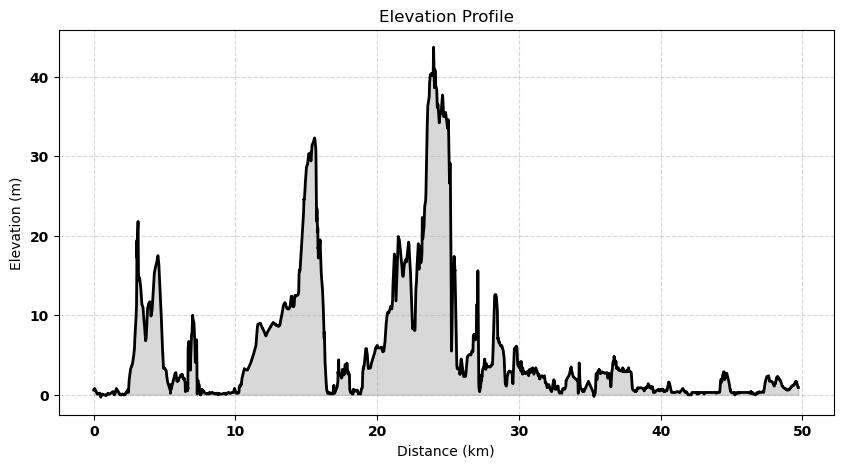

In [441]:
#Plot
plt.figure(figsize=(10, 5))
plt.plot(df["Distance (km)"], df["Elevation (m)"], color="black", linewidth=2)
plt.fill_between(df["Distance (km)"], df["Elevation (m)"], color="gray", alpha=0.3)
plt.xlabel("Distance (km)")
plt.ylabel("Elevation (m)")
plt.title("Elevation Profile")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [14]:
df.head()

,Distance (km),Elevation (m)
0,0.000000,0.6
1,0.009523,0.6
2,0.023018,0.6
3,0.024505,0.6
4,0.025618,0.6


In [16]:
import pandas as pd
import re

# Load CSV
file_path = "ManhattanPOI.csv" 
POI_df = pd.read_csv(file_path)



In [18]:
# Extract latitude and longitude using regex
POI_df[['Longitude', 'Latitude']] = POI_df['WKT'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')

# Convert to float
POI_df['Longitude'] = POI_df['Longitude'].astype(float)
POI_df['Latitude'] = POI_df['Latitude'].astype(float)

POI_df

,WKT,name,description,Longitude,Latitude
0,POINT (-73.9987172 40.7645602),Intrepid Museum,NaN,-73.998717,40.764560
1,POINT (-74.0036345 40.705493),Restroom,NaN,-74.003635,40.705493
2,POINT (-74.0035333 40.7057003),South Street Seaport,NaN,-74.003533,40.705700
3,POINT (-74.0158905 40.7044284),Restroom,NaN,-74.015890,40.704428
4,POINT (-74.0151815 40.7020193),The Battery,NaN,-74.015181,40.702019
5,POINT (-73.9465272 40.8485679),George Washington Bridge,NaN,-73.946527,40.848568
6,POINT (-73.9462939 40.8472638),Restroom,NaN,-73.946294,40.847264
7,POINT (-73.9445277 40.7729724),John Finley Walk,NaN,-73.944528,40.772972
8,POINT (-73.9653124 40.8137966),Riverside Park,NaN,-73.965312,40.813797
9,POINT (-73.9946094 40.7719581),Restroom,NaN,-73.994609,40.771958


In [20]:
POI_df = POI_df.drop(['WKT', 'description'], axis=1)

In [22]:
POI_df

,name,Longitude,Latitude
0,Intrepid Museum,-73.998717,40.764560
1,Restroom,-74.003635,40.705493
2,South Street Seaport,-74.003533,40.705700
3,Restroom,-74.015890,40.704428
4,The Battery,-74.015181,40.702019
5,George Washington Bridge,-73.946527,40.848568
6,Restroom,-73.946294,40.847264
7,John Finley Walk,-73.944528,40.772972
8,Riverside Park,-73.965312,40.813797
9,Restroom,-73.994609,40.771958


In [24]:
POI_df.to_csv("cleaned_poi.csv", index=False)

In [435]:

file_path = "cleaned_poi.csv"
poi_df = pd.read_csv(file_path)

# Separate Restrooms and Other POIs
restroom_df = poi_df[poi_df["name"].str.contains("Restroom", na=False)]
poi_only_df = poi_df[~poi_df["name"].str.contains("Restroom", na=False)]

# Save to separate CSVs
restroom_df.to_csv("restrooms.csv", index=False)
poi_only_df.to_csv("poi_only.csv", index=False)

print("CSV files created: restrooms.csv and poi_only.csv")


CSV files created: restrooms.csv and poi_only.csv


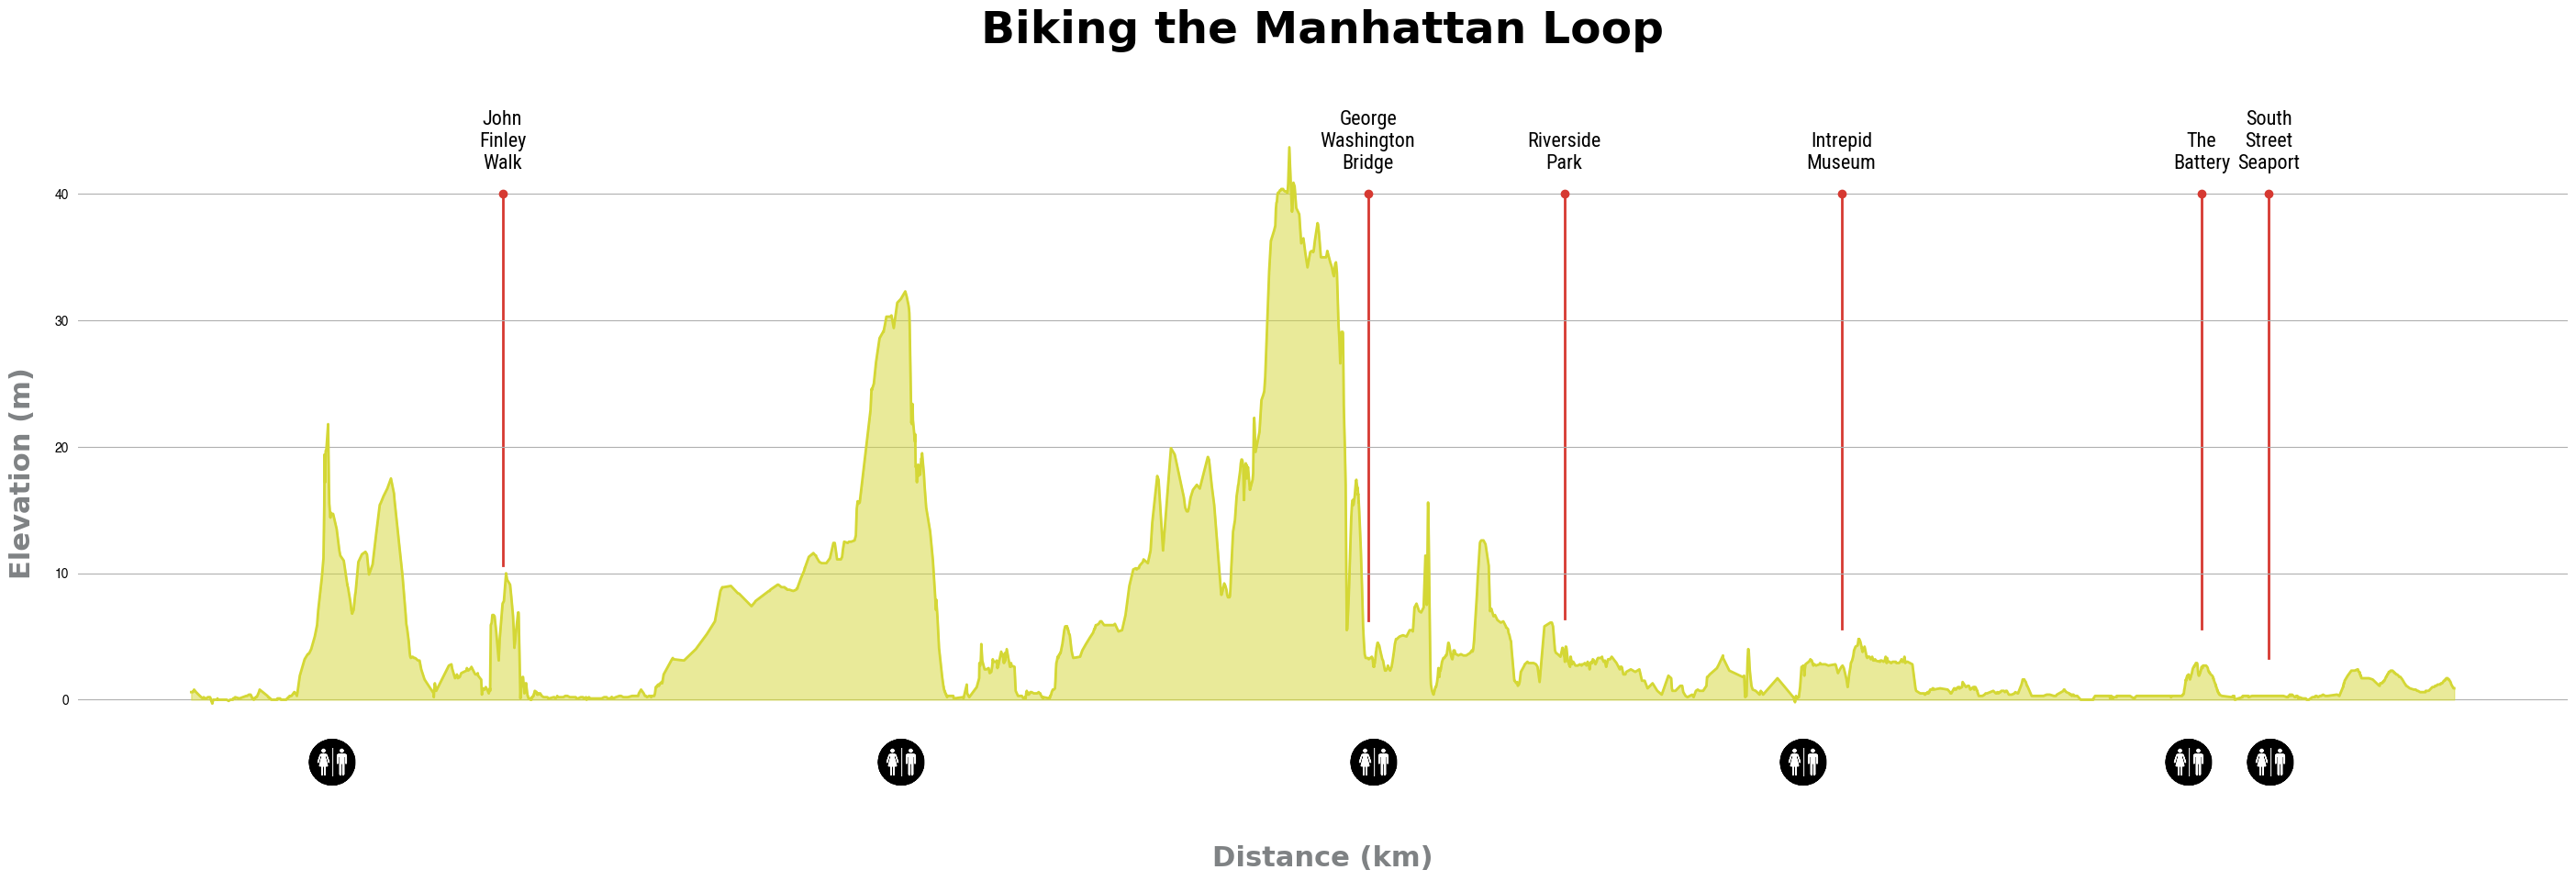

In [437]:
import pandas as pd
import gpxpy
import gpxpy.gpx
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import numpy as np
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import matplotlib.font_manager as font_manager



# Load POIs
poi_df = pd.read_csv("poi_only.csv")
restroom_df = pd.read_csv("restrooms.csv")

# Load GPX file
with open("Manhattan_Loop.gpx", "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Extract track points
lats, lons, elevations, distances = [], [], [], []
distance = 0  # Cumulative distance

prev_point = None
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            elevations.append(point.elevation)

            if prev_point:
                # Calculate distance (approximate)
                delta_dist = np.sqrt((point.latitude - prev_point.latitude)**2 + (point.longitude - prev_point.longitude)**2)
                distance += delta_dist * 111  # Convert degrees to km
            distances.append(distance)
            prev_point = point

# Convert to NumPy array for fast searching
track_coords = np.column_stack((lats, lons))
track_tree = cKDTree(track_coords)

# Match POIs to nearest track points
poi_distances = []

for _, row in poi_df.iterrows():
    poi_coord = [row["Latitude"], row["Longitude"]]
    _, idx = track_tree.query(poi_coord)  # Find nearest GPX point
    poi_distances.append(distances[idx])

# Plot elevation profile
plt.figure(figsize=(35, 10))
plt.plot(distances, elevations, label="Route Elevation", color="#d4d735", linewidth=2, zorder=2)

# Set POIs at a fixed height of 25
poi_height = 40
plt.scatter(poi_distances, [poi_height] * len(poi_distances), color="#d63931", zorder=3, label="POIs")

# Add labels above the POIs with condensed font
font_path = 'RobotoCondensed-VariableFont_wght.ttf' 
font_prop = font_manager.FontProperties(fname=font_path)

for i, row in poi_df.iterrows():
    name_with_breaks = "\n".join(row["name"].split(" "))  # Split and join with newline
    plt.annotate(name_with_breaks, (poi_distances[i], poi_height+2),
             fontproperties=font_prop, fontsize=16, ha='center')


# Match Restrooms to nearest track points
restroom_distances = []

for _, row in restroom_df.iterrows():
    restroom_coord = [row["Latitude"], row["Longitude"]]
    _, idx = track_tree.query(restroom_coord)  # Find nearest GPX point
    restroom_distances.append(distances[idx])


#Load Restoom Icon
image_path = "restroom_icon2.png"
restroom_icon = Image.open(image_path)
#Create Offset Image
imagebox = OffsetImage(restroom_icon, zoom=0.30) # Adjust zoom for desired size


for i, row in restroom_df.iterrows():
    ab = AnnotationBbox(imagebox, (restroom_distances[i], -5), frameon=False, xycoords='data', pad=0)
    plt.gca().add_artist(ab)   

ax = plt.gca()  # Get the current axis
for spine in ax.spines.values():
    spine.set_visible(False)

for i, row in poi_df.iterrows():
    # Get the x position of the POI and its height
    x_pos = poi_distances[i]
    y_pos = poi_height
    
    # Get the elevation at the current distance
    elevation_at_distance = elevations[distances.index(poi_distances[i])]
    
    # Calculate the line length as the difference between 40 and the elevation
    line_length = y_pos - (elevation_at_distance+3)
    
    # Plot the red line extending downward from the POI
    plt.plot([x_pos, x_pos], [y_pos, y_pos - line_length], color="#d63931", lw=2, zorder=1)

# Labels & Styles

headerFont = { 'fontsize':35, 'color':"black", 'weight':900}
labelFont = {'weight':900, 'fontsize': 22, 'color':"#7f8284"}
plt.ylim(bottom=-10)
plt.xticks([])
plt.yticks(range(0, 50, 10))
plt.tick_params(left = False, labelfontfamily='Helvetica') 
plt.fill_between(distances, elevations, color="#d4d735", zorder=3, alpha=.5)
plt.xlabel("Distance (km)", labelpad=15, **labelFont)
plt.ylabel("Elevation (m)", labelpad=15,  **labelFont)
plt.title("Biking the Manhattan Loop", pad=60, **headerFont)
plt.grid(True)


#Save plot
plt.savefig("ManhattanLoopChart.svg")

# Show plot
plt.show()


In [32]:
restroom_df

,name,Longitude,Latitude
0,Restroom,-74.003635,40.705493
1,Restroom,-74.015890,40.704428
2,Restroom,-73.946294,40.847264
3,Restroom,-73.994609,40.771958
4,Restroom,-73.939961,40.827937
5,Restroom,-73.968691,40.748102


In [34]:
restroom_df.iloc[4,2] = 40.7481
restroom_df.iloc[4,1] = -73.96869
restroom_df

,name,Longitude,Latitude
0,Restroom,-74.003635,40.705493
1,Restroom,-74.015890,40.704428
2,Restroom,-73.946294,40.847264
3,Restroom,-73.994609,40.771958
4,Restroom,-73.968690,40.748100
5,Restroom,-73.968691,40.748102


In [36]:
#Import folium for map vizualization
import folium
from folium import Popup

In [38]:
poi_df

,name,Longitude,Latitude
0,Intrepid Museum,-73.998717,40.764560
1,South Street Seaport,-74.003533,40.705700
2,The Battery,-74.015181,40.702019
3,George Washington Bridge,-73.946527,40.848568
4,John Finley Walk,-73.944528,40.772972
5,Riverside Park,-73.965312,40.813797



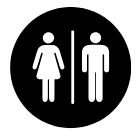
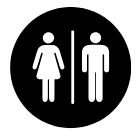
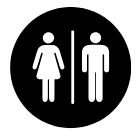
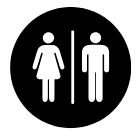
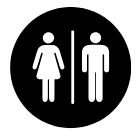
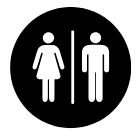
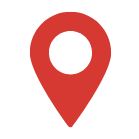
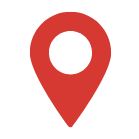
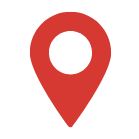
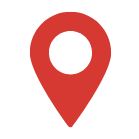
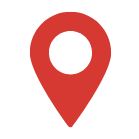
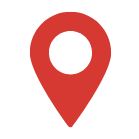

In [443]:
# Load POIs & Restrooms
poi_df = pd.read_csv("poi_only.csv")
restroom_df = pd.read_csv("restrooms.csv")

# Load GPX File
with open("Manhattan_Loop.gpx", "r") as gpx_file:
    gpx = gpxpy.parse(gpx_file)

# Extract track points
lats, lons, elevations, distances = [], [], [], []
distance = 0  # Cumulative distance tracker
prev_point = None

for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            lats.append(point.latitude)
            lons.append(point.longitude)
            elevations.append(point.elevation)

            if prev_point:
                delta_dist = np.sqrt((point.latitude - prev_point.latitude)**2 + (point.longitude - prev_point.longitude)**2)
                distance += delta_dist * 111  # Convert degrees to km
            distances.append(distance)
            prev_point = point

# Convert to NumPy array for fast searching
track_coords = np.column_stack((lats, lons))
track_tree = cKDTree(track_coords)

# Initialize Folium Map
map_center = [np.mean(lats), np.mean(lons)]  # Center map at midpoint
m = folium.Map(location=map_center, zoom_start=12, tiles="cartodbpositron")



# Add GPX Track
track_line = list(zip(lats, lons))
folium.PolyLine(track_line, color="#d4d735", weight=6, opacity=0.8, tooltip="Bike Route").add_to(m)

# Function to add markers
def add_marker(lat, lon, popup_text, icon_url, icon_size=(30, 30)):
    icon = folium.CustomIcon(icon_url, icon_size)
    folium.Marker(location=[lat, lon], popup=popup_text, icon=icon).add_to(m)


# Add Restrooms
for _, row in restroom_df.iterrows():
    add_marker(row["Latitude"], row["Longitude"], None, "restroom_icon2.png")


# Add POIs
for _, row in poi_df.iterrows():
    adjusted_lat = row["Latitude"]+ 0.0035
    poi_name = row["name"]
    
    image_filename = f"poi_{poi_name.replace(' ', '_')}.jpg"
    image_url = f"https://raw.githubusercontent.com/chezseashell/BikeLoopChart/refs/heads/main/images/{image_filename}"
    
    # Create HTML content for popup
    popup_html = f"""
    <div style=" text-align: center; width: 20vw; padding: 0; margin: 0;">
    <div style="font-family: "Helvetica Neue", Arial, Helvetica, sans-serif;
text-align: center; margin: 0; padding: 0;">
        <div style="color: white; font-size: 1.5rem; font-weight: 600; padding: 10px; text-align: center;">
            {poi_name}
        </div>
        <img src="{image_url}" 
             style="
                 display: block;
                 width: 100%;
                 height: auto;
                 margin: 0;
                 padding: 0;
                 border: none;
            ">
    </div>
"""
    add_marker(row["Latitude"]+ 0.0035, row["Longitude"], popup_html, "poi_icon.png", icon_size=(45, 45))


# folium.TileLayer(
#     tiles='https://tiles.stadiamaps.com/tiles/stamen_toner_lite/{z}/{x}/{y}{r}.png',
#     attr='&copy; <a href="https://www.stadiamaps.com/" target="_blank">Stadia Maps</a> &copy; <a href="https://www.stamen.com/" target="_blank">Stamen Design</a> &copy; <a href="https://openmaptiles.org/" target="_blank">OpenMapTiles</a> &copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors',
#     name="Stamen Toner Lite"
# ).add_to(m)
folium.TileLayer('CartoDB positron').add_to(m)  # Light gray basemap


m.get_root().html.add_child(folium.Element("""
    <style>
        .leaflet-popup-content-wrapper {
            border-radius: 0px !important;
            background-color: black !important; /* Remove gray background */
            padding: 0 !important;
        }
        
        .leaflet-popup-content {
            width: 100% !important;
            margin: 0 !important;
            padding: 0 !important;
        }

        .leaflet-popup-tip {
            display: none;
        }
        .leaflet-popup-close-button{
                color:#d4d735 !important;;
        }
    </style>
"""))

m

In [432]:
m.save("Manhattan_Loop_Map.html")